In [1]:
import fxcmpy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyti.exponential_moving_average import exponential_moving_average as ema
%matplotlib inline
pd.options.display.max_rows = 4000

/home/lois/delivery/TECK-4/market_finance_introduction/venv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
con = fxcmpy.fxcmpy(config_file='fxcm.cfg')

In [3]:
def calculPeriodEMAv(i, val, tabEMAv, data, periodValue):
    if i == periodValue:
        return np.array(data[0:i], dtype=np.float32).mean()
    if i > periodValue:
        return val * (2/(periodValue+1)) +  tabEMAv[-1] * (1- (2/(periodValue+1)))
    elif i < periodValue:
        return None

In [49]:
def initEMAv(data):
    i = 1
    p_5 = []
    p_20 = []
    p_50 = []
    periodEMAv = ['p_5', 'p_20', 'p_50']
    for val in data['askclose']:            
        p_5.append(calculPeriodEMAv(i, val, p_5, data['askclose'], 12))
        p_20.append(calculPeriodEMAv(i, val, p_20, data['askclose'], 20))
        #p_20.append(ema(data['askclose'], 5))
        p_50.append(calculPeriodEMAv(i, val, p_50, data['askclose'], 50))
        i += 1
    emav = pd.DataFrame(columns=periodEMAv)
    emav['p_5']= (p_5)
    #emav['p_5']= ema(data['askclose'], 12)
    emav['p_20']= (p_20)
    #emav['p_20']= ema(data['askclose'], 20)
    emav['p_50']= (p_50)
    emav.index = data.index
    return (emav)

In [5]:
def calculsen(i, data, offset):
    # tenkan = (H+B)/2
    # H  max du prix sur offset bougies precedente
    # B  min du prix sur offset bougies precedente
    if i < offset:
        return None
    else:
        return ((max(data['askhigh'][i-offset:i]) + min(data['asklow'][i-offset:i])) / 2)     

In [6]:
def calculspan(i ,data, offset, types, tenkan, kijun):
    if i < offset:
        return None
    if types == 'Chikou':
        return data['askclose'][i - offset]
    if types == 'SenkouA':
        if kijun[i - offset] != None:
            return (tenkan[i - offset] + kijun[i - offset]) / 2
        else:
            return None
    if types == 'SenkouB':
        return ((max(data['askhigh'][i-offset:i]) + min(data['asklow'][i-offset:i])) / 2)

In [72]:
def initIchimoku(data):
    i = 0
    tenkan_sen = []
    kijun_sen = []
    chikou_span = []
    senkou_spanA = []
    senkou_spanB = []
    kumo = []
    for val in data['askclose']:
        tenkan_sen.append(calculsen(i, data, 9))
        kijun_sen.append(calculsen(i, data, 26))
        chikou_span.append(calculspan(i, data, 26, 'Chikou', tenkan_sen, kijun_sen))
        senkou_spanA.append(calculspan(i, data, 26, 'SenkouA', tenkan_sen, kijun_sen))
        ok = calculspan(i, data, 52, 'SenkouB', tenkan_sen, kijun_sen)
        if senkou_spanB and senkou_spanB[-1] == None and ok != None:
            for z in range(26):
                senkou_spanB.append(None)
            senkou_spanB.append(ok)
        else:
            senkou_spanB.append(ok)
        i += 1
    print(senkou_spanB[:30])
    print(senkou_spanA[:30])
    ichimoku = pd.DataFrame()
    ichimoku['tenkan'] = tenkan_sen
    ichimoku['kijun'] = kijun_sen
    ichimoku['chikou'] = chikou_span
    ichimoku['senkouA'] = senkou_spanA
    ichimoku['senkouB'] = senkou_spanB
    return ichimoku

In [8]:
def decisionIchimoku(data, ichimoku):
    # nuage  = Kumo : nuage enter senkouA et SenkouB
    # haussier fort : prix au dessus du nuage, tenkan > kijun, roisement au dessus du nuage, chikou au dessus de prix
    
    if data['askclose'][-1] > ichimoku['senkouA'][-1] and data['askclose'][-1] > ichimoku['senkouB'][-1]:
        if ichimoku['chikou'][-1] > data['askclose'][-1]:
            if ichimoku['tekan'][-2] < ichimoku['kijun'][-2] and ichimoku['tekan'][-1] > ichimoku['kijun'][-1]:
                if ichimoku['tenkan'][-1] > ichimoku['senkouA'][-1] and ichimoku['tenkan'][-1] > ichimoku['senkouB'][-1]:
                    # haussier fort au dessus du nuage
                    print("la")
                if ichimoku['tenkan'][-1] < ichimoku['senkouA'][-1] and ichimoku['tenkan'][-1] < ichimoku['senkouB'][-1]:
                    # haussier faible au dessous du nuage
                    print("la")
                else:
                    print("la")
                    # haussier moyen dans le nuage

    if data['askclose'][-1] < ichimoku['senkouA'][-1] and data['askclose'][-1] < ichimoku['senkouB'][-1]:
        if ichimoku['chikou'][-1] < data['askclose'][-1]:
            if ichimoku['tekan'][-2] > ichimoku['kijun'][-2] and ichimoku['tekan'][-1] < ichimoku['kijun'][-1]:
                if ichimoku['kijun'][-1] < ichimoku['senkouA'][-1] and ichimoku['kijun'][-1] < ichimoku['senkouB'][-1]:
                    # baissier fort au dessus du nuage
                    print("la")
                if ichimoku['kijun'][-1] > ichimoku['senkouA'][-1] and ichimoku['kijun'][-1] > ichimoku['senkouB'][-1]:
                    # baissier faible au dessous du nuage
                    print("la")
                else:
                    print("la")
                    # baissier moyen dans le nuage

In [9]:
def decisionEMAv(data, EMAv):
    # ENTRY LOGIC 
    # buy if p5 go upper than p20 
    if EMAv['p_5'][-2] < EMAv['p_20'][-1] and EMAv['p_5'][-1] > EMAv['p_20'][-1]:
        # P20 and p5 are upper p50 and last price upper p50
        if EMAv['p_20'][-1] > EMAv['p_50'][-1] and data['askclose'][-1] > EMAv['p_50'][-1]:
            ### je achete
            # TODO if exsting open trade don't open !!!!!!!!
             con.create_market_buy_order(self.instrument, 100)

    # EXIT LOGIC 
    # sell if p5 go under than p20 
    if EMAv['p_5'][-2] > EMAv['p_20'][-1] and EMAv['p_5'][-1] < EMAv['p_20'][-1]:
        # P20 and p5 are under p50 and last price under p50
        if EMAv['p_20'][-1] < EMAv['p_50'][-1] and data['askclose'][-1] < EMAv['p_50'][-1]:
            ### je vend
            # TODO if open trade exit other don't do anithing !!!!!!!!
            con.create_market_sell_order(self.instrument, 100)

In [66]:
class BacktestingFXCM:
    def __init__(self, instrument, frequency, start, end):
        # smallest change value 
        self.pip = .0879
        # basic number of lot order 
        self.lot_size = 10
        self.instrument = instrument
        self.frequency = frequency
        # exemple of str to send '2018-06-29 08:15:27'
        date_time_start = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
        date_time_end = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
        self.data = con.get_candles(instrument, period=frequency, start=date_time_start, end=date_time_end)
        utils_columns = ['askclose', 'bidclose','askhigh', 'asklow', 'askopen']
        self.data = self.data[utils_columns]
        #self.EMAv = initEMAv(self.data)
        self.ichimoku = initIchimoku(self.data)
        self.result = pd.DataFrame(columns=['position', 'position_test'])



    def calculPositionEMAv(self):
        #self.result['position'] = np.where(self.EMAv['p_5'] > self.EMAv['p_20'], 1, 0)
        self.result['position'] = np.where(
            (self.EMAv['p_5'] > self.EMAv['p_20']) 
            & 
            (self.EMAv['p_20'] > self.EMAv['p_50']) & (self.data['askclose'] > self.EMAv['p_50'])
                                          ,1,0)
        self.result['signal'] = self.result['position'].diff()
        self.result['signal_test'] = self.result['position_test'].diff()
        self.result['difference_pips'] = (self.data['askclose'].values - self.data['askopen'].values) * 100
      

    def calculPositionIchimoku(self):
        self.result['position'] = np.where((self.data['askclose'] > self.ichimoku['senkouA']) & (self.data['askclose'] > self.ichimoku['senkouB'])
                                           & (self.ichimoku['chikou'] >self.data['askclose'] & 
                                             (self.ichimoku['tenkan'] > self.ichimoku['kinju'])), 1,0)
        self.result['signal'] = self.result['position'].diff()
        self.result['difference_pips'] = (self.data['askclose'].values - self.data['askopen'].values) * 100
    
    
    def calculProfit(self):
        returns = 0
        CountPL=False
        print("calcul profit")
        for i, row in self.result.iterrows():
            if CountPL==True:
                returns += (row['difference_pips'] * self.pip * self.lot_size)
                self.result.loc[i,'total'] = returns
            else:
                self.result.loc[i,'total'] = returns
            if row['position'] == 1:
                CountPL=True
            else:
                CountPL=False


    def plotting(self):
        fig = plt.figure(figsize=(42,32))
        ax1 = fig.add_subplot(111,  ylabel='GBP/JPY Price')
        dataplot = self.data.merge(self.result, left_on=self.result.index, right_index=True).reset_index()
        dataplot = dataplot.merge(self.EMAv, on='date')
        dataplot['askclose'].plot(ax=ax1, color='r', lw=2, label='askclose')
        dataplot[['p_5','p_20', 'p_50']].plot(ax=ax1, lw=1)
        
        ax1.plot(dataplot.loc[dataplot.position == 1.0].index,
         dataplot.p_5[dataplot.position == 1.0],
         'D', markersize=10, color='k' )
        ax1.plot(dataplot.loc[dataplot.position == -1.0].index,
         dataplot.p_20[dataplot.position == -1.0],
         'X', markersize=10, color='m')
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Profit $')
        ax2.plot(dataplot['total'], color='m', lw=3)

In [11]:
class tradeFXCM:
    def __init__(self, instrument, frequency):
        # smallest change value 
        self.pip = .0879
        # basic number of lot order
        self.lot_size = 10
        self.instrument = instrument
        self.frequency = frequency
        self.data = con.get_candles(instrument, period=frequency, number=100)
        utils_columns = ['askclose', 'bidclose','askhigh', 'asklow']
        self.data = self.data[utils_columns]
        self.EMAv = initEMAv(self.data)
        selk.ichimoku = initIchimoku(self.data)
        
        # a faire en dernier
        self.time_update = datetime.datetime.now()
        print(self.time_update)
    

    
    # Exponentielle moving average instead of moving average
    # better reaction to last price
    def ExpMovingAvCalc(self):
        self.EMAv.append(
            {
                'p_5' :
                calculPeriodEMAv(len(self.data), self.data['askclose'].iloc[-1], self.EMAv['p_5'].tolist(), self.data['askclose'], 5)
            }, 
            { 
                'p_20' :
                calculPeriodEMAv(len(self.data), self.data['askclose'].iloc[-1], self.EMAv['p_20'].tolist(), self.data['askclose'], 20)
            },
            {
                'p_50' :
                calculPeriodEMAv(len(self.data), self.data['askclose'].iloc[-1], self.EMAv['p_50'].tolist(), self.data['askclose'], 50)
            }
        )
        
        
    def IchimokuCalc(self):
        self.ichimoku.append(
            {
                'tenkan': calculsen(len(self.data), self.data, 9) 
            },
            {
                'kijun' : calculsen(len(self.data), self.data, 26)
            },
            {
                'chikou': calculspan(len(self.data), self.data, 26, 'Chikou', None, None)
            },
            {
                'senkouA' : calculspan(len(self.data), self.data, 26, 'SenkouA', self.ichimoku['tenkan'], self.ichimoku['kijun'])
            },
            {
                'senkouB' : calculspan(len(self.data), self.data, 52, 'SenkouB', None, None)
            }
        )
    
    
    def update(self):
        temp = con.get_candles(self.instrument, period=self.frequency, number=1)
        temp = temp[['askclose', 'bidclose']]
        self.data = self.data.append(temp)
        #self.time_update = self.data.last_valid_index()
        self.time_update = datetime.datetime.now()
        print('ma valeur index qui marche pas')
        print(self.data.last_valid_index())
        print(temp)
        # add EMAv new
        self.ExpMovingAvCalc()
        #self.IchimokuCalc()
       


In [12]:
all_frequency = ['m1','m5', 'm15', 'm30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'D1', 'W1']
all_instrument = ['EUR/USD']

# BACKTESTING

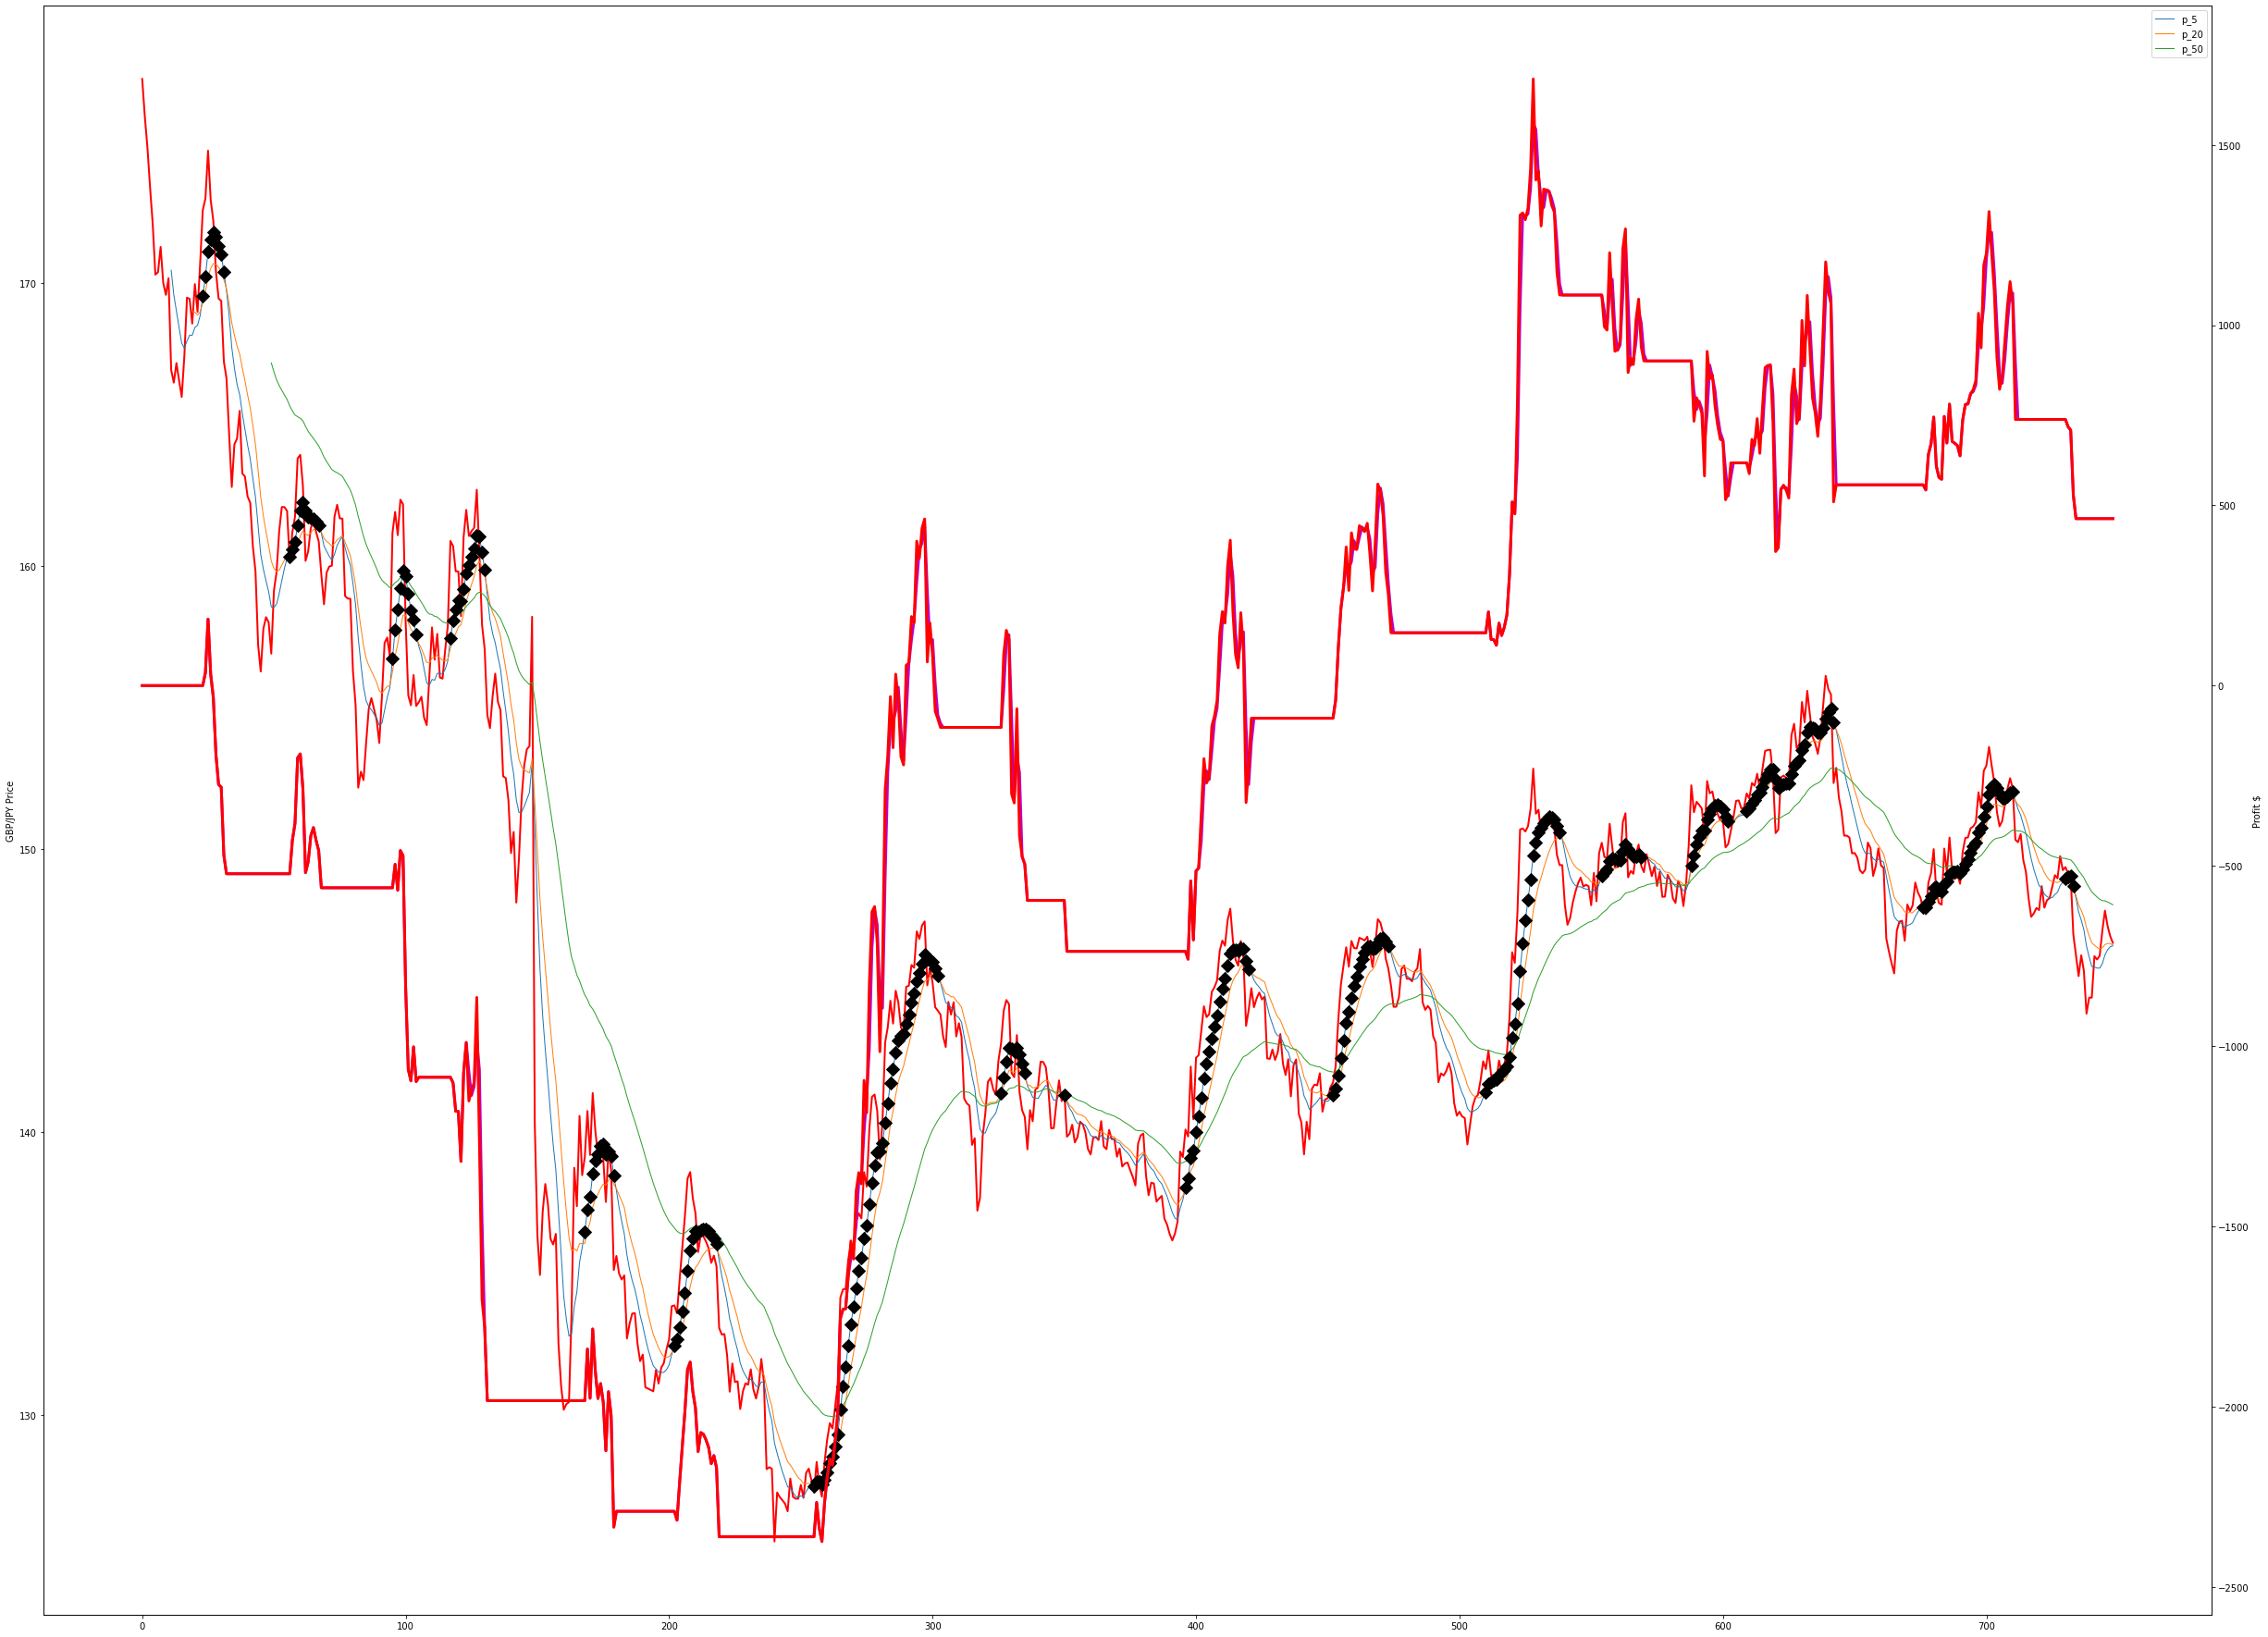

In [34]:
start = '2016-01-01 00:00:00'
end = '2018-06-10 00:00:00'
test = BacktestingFXCM('GBP/JPY', 'D1', start, end)
test.calculPositionEMAv()
test.calculProfit()
test.plotting()

In [73]:
start = '2016-01-01 00:00:00'
end = '2018-06-10 00:00:00'
testUSD = BacktestingFXCM('EUR/USD', 'D1', start, end)
testUSD.calculPositionEMAv()
testUSD.calculPositionIchimoku()
#testUSD.plotting()
print(testUSD.result.columns)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


ValueError: Length of values (783) does not match length of index (757)

In [64]:
print(testUSD.result['total'].iloc[-1])

-0.04746599999999995


In [51]:
# mon calcul sur la emav
print(testUSD.result['total'].iloc[-1])

-0.04746599999999995


In [47]:
# ma condition
print(testUSD.result['total'].iloc[-1])

-1.1172090000000392


In [44]:
# le leur tutorial exemple
print(testUSD.result['total'].iloc[-1])

-4.251723000000043


# TRADING

In [ ]:
all_market = []
all_market.append(tradeFXCM('EUR/USD', 'm1'))

In [ ]:
while 1:
    for market in all_market:
        c = datetime.datetime.now() - market.time_update
        #check one minute
        if c.seconds / 60 >= 0.3:
            market.update()
            #decisionEMAv(self.data, self.EMAv)

In [ ]:
con.close()